In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import json
import numpy as np
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'deeplearning/05-kaggle_cooking'))
    print(os.getcwd())
except IOError:
    pass

In [4]:
# Dataset Preparation
print ("Read Dataset ... ")
def read_dataset(path):
	return json.load(open(path)) 
train = read_dataset('../data/kaggle_cooking/train.json')
test = read_dataset('../data/kaggle_cooking/test.json')

Read Dataset ... 


In [5]:
print ("Prepare text data of Train and Test ... ")
def generate_text(data):
	text_data = [" ".join(doc['ingredients']).lower() for doc in data]
	return text_data

train_text = generate_text(train)
test_text = generate_text(test)
target = [doc['cuisine'] for doc in train]
print(target)
print(len(target))
target_set=set(target)
print(target_set)
print(len(target_set))

Prepare text data of Train and Test ... 
['greek', 'southern_us', 'filipino', 'indian', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'italian', 'italian', 'chinese', 'italian', 'mexican', 'italian', 'indian', 'british', 'italian', 'thai', 'vietnamese', 'thai', 'mexican', 'southern_us', 'chinese', 'italian', 'chinese', 'cajun_creole', 'italian', 'chinese', 'mexican', 'italian', 'cajun_creole', 'mexican', 'thai', 'italian', 'cajun_creole', 'italian', 'filipino', 'southern_us', 'southern_us', 'italian', 'brazilian', 'mexican', 'indian', 'mexican', 'chinese', 'french', 'southern_us', 'southern_us', 'southern_us', 'japanese', 'southern_us', 'italian', 'southern_us', 'italian', 'jamaican', 'japanese', 'indian', 'italian', 'irish', 'thai', 'thai', 'indian', 'jamaican', 'italian', 'thai', 'korean', 'french', 'french', 'southern_us', 'spanish', 'indian', 'moroccan', 'italian', 'italian', 'moroccan', 'moroccan', 'vietnamese', 'japanese', 'mexican', 'cajun_creole', 'southern_us', 'frenc

In [6]:
tfidf = TfidfVectorizer(binary=True)
def tfidf_features(txt, flag):
    if flag == "train":
        x = tfidf.fit_transform(txt)
    else:
        x = tfidf.transform(txt)
    x = x.astype('float16')
    return x 
X = tfidf_features(train_text, flag="train")
X_test = tfidf_features(test_text, flag="test")

In [7]:
lb = LabelEncoder()
y = lb.fit_transform(target)
print(y)
y = keras.utils.to_categorical(y)
print(y)

[ 6 16  4 ...  8  3 13]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
model = keras.Sequential()
model.add(keras.layers.Dense(300, kernel_initializer=keras.initializers.he_normal(seed=1), activation='relu', input_dim=3010))
model.add(keras.layers.Dropout(0.81))
model.add(keras.layers.Dense(300, kernel_initializer=keras.initializers.he_normal(seed=2), activation='relu'))
model.add(keras.layers.Dropout(0.81))
model.add(keras.layers.Dense(20, kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=4), activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
history = model.fit(X, y, epochs=30, batch_size=512, validation_split=0.1)
model.save_weights("../models/kaggle_cooking/weights_kaggle_cooking.h5")
print("Saved weights to disk")
model_json = model.to_json()
with open("../models/kaggle_cooking/model_kaggle_cooking.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model to json")
model.save("../models/kaggle_cooking/model_kaggle_cooking.h5")
print("Saved model to disk")


Train on 35796 samples, validate on 3978 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
35796/35796 [==============================] - 3s 72us/sample - loss: 2.5410 - acc: 0.2393 - val_loss: 2.0303 - val_acc: 0.4309
Epoch 2/30
35796/35796 [==============================] - 2s 68us/sample - loss: 1.8242 - acc: 0.4840 - val_loss: 1.4094 - val_acc: 0.5696
Epoch 3/30
35796/35796 [==============================] - 2s 68us/sample - loss: 1.4486 - acc: 0.5724 - val_loss: 1.1548 - val_acc: 0.6390
Epoch 4/30
35796/35796 [==============================] - 2s 69us/sample - loss: 1.2723 - acc: 0.6182 - val_loss: 1.0200 - val_acc: 0.6943
Epoch 5/30
35796/35796 [==============================] - 2s 68us/sample - loss: 1.1704 - acc: 0.6501 - val_loss: 0.9436 - val_acc: 0.7137
Epoch 6/30
35796/35796 [==============================] - 2s 67us/sample - loss: 1.1062 - acc: 0.6719 - val_loss: 0.8928 - val_acc: 0.7272
Epoch 7/30
35796/35796 [==============================] - 2s 67us/sam

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


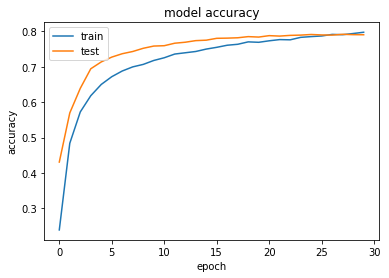

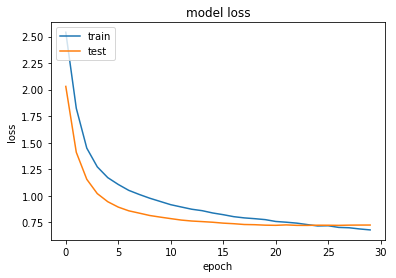

In [10]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [11]:
predictions_encoded = model.predict(X_test)
predictions_encoded.shape


(9944, 20)

In [12]:
predictions = lb.inverse_transform([np.argmax(pred) for pred in predictions_encoded])
print(predictions)


['irish' 'southern_us' 'italian' ... 'italian' 'southern_us' 'mexican']


In [13]:
test_id = [doc['id'] for doc in test]
sub = pd.DataFrame({'id': test_id, 'cuisine': predictions}, columns=['id', 'cuisine'])
sub.head()

,id,cuisine
0,18009,irish
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
